# Forecasting

#### Choosing a Model 

Here, we will use Holt-Winters.

#### Split data into train and test sets

Typically the test data should be at least as long as the forecasting horizon required, but there is no right or wrong answer, it all depends.

If you have 100 years worth of data, but only want to forecast 1 month, then test set can be quite small.

The larger the forecasting period, the less accurate the predictions become, because one predicts on based predictions, so errors compound.

#### Fit model on training set
#### Evalulate model on test set

MAE is the mean of the absolute value of errors. It is just how far off the model is on average. However, the issue is that it does not alert us if the forecast was really off just for a few points (because this would be averaged out). 

So it is more common to use the mean squared error (MSE), large errors are noted more than with the MAE. This is why MSE is more popular. However, now the units of the MSE are also squared, making it hard to interpret.

The workaround is using the Root Mean Square Error (RSME), which is the mean of the squared errors. The goodness of the error magnitude depends on the type of data. Use your own judgement, compare RSME to average values in training and test set. There is no good value, it all depends.


#### Re-fit model on entire data set
#### Forecast for future data

,BTC
date,
2013-04-29,144.54
2013-04-30,139.00
2013-05-01,116.99
2013-05-02,105.21
2013-05-03,97.75


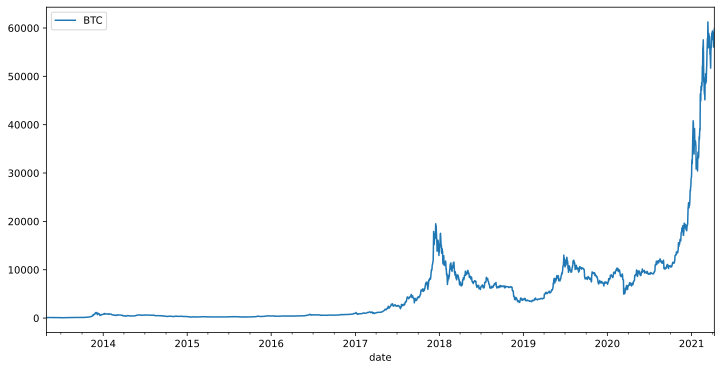

In [60]:
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import set_matplotlib_formats
import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter
set_matplotlib_formats('svg')

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

folder = f'../02.Prepared_data/2021-04-11/'

def load_coins(folder):
#     folder = f'../02.Prepared_data/2021-04-05/'
    
    BTC = pd.read_csv(f"{folder}/BTC_Bitcoin.csv", index_col=0, parse_dates=['date'])
    ETH = pd.read_csv(f"{folder}/ETH_Ethereum.csv", index_col=0, parse_dates=['date'])
    XMR = pd.read_csv(f"{folder}/XMR_Monero.csv", index_col=0, parse_dates=['date'])
    DASH = pd.read_csv(f"{folder}/DASH_Dash.csv", index_col=0, parse_dates=['date'])
    LTC = pd.read_csv(f"{folder}/LTC_Litecoin.csv", index_col=0, parse_dates=['date'])
    XRP = pd.read_csv(f"{folder}/XRP_XRP.csv", index_col=0, parse_dates=['date'])
    ADA = pd.read_csv(f"{folder}/ADA_Cardano.csv", index_col=0, parse_dates=['date'])
    DOT = pd.read_csv(f"{folder}/DOT_Polkadot.csv", index_col=0, parse_dates=['date'])

    coins = [ETH, XMR, DASH, LTC, XRP, ADA, DOT]
    # make sure that all have date as index
    new_coins = []
    for df in coins:
        df = df.sort_values(by='date')
        df = df.drop_duplicates(subset='date', keep='first')
        df = df.set_index('date', drop=True)
        df = df.asfreq('D', method='ffill')
        new_coins.append(df)

    BTC = BTC.sort_values(by='date')
    BTC = BTC.drop_duplicates(subset='date', keep='first')
    BTC = BTC.set_index('date', drop=True)
    BTC = BTC.asfreq('D', method='ffill')
    coins = [BTC] + new_coins

    cols = ['BTC', 'ETH', 'XMR', 'DASH', 'LTC', 'XRP', 'ADA', 'DOT']
    df = pd.DataFrame()

    for col, coin in zip(cols, coins):
        vals = coin['close'].asfreq('D', method='ffill') # in case there were some skipped days
        df[col] = vals
        
    return df


coins = load_coins(folder)
BTC = pd.DataFrame()
BTC['BTC'] = coins['BTC']

BTC.loc[:].plot(figsize=(12,6))
BTC.head()

## Split data into train and test sets

In [61]:
train_data = BTC.loc[:"Dec 2020"]
test_data = BTC.loc["Jan 2021":]
train_data.tail()

,BTC
date,
2020-12-27,26272.29
2020-12-28,27084.81
2020-12-29,27362.44
2020-12-30,28840.95
2020-12-31,29001.72


In [62]:
test_data.head()

,BTC
date,
2021-01-01,29374.15
2021-01-02,32127.27
2021-01-03,32782.02
2021-01-04,31971.91
2021-01-05,33992.43


## Fit model on training set

In [117]:
fitted_model = ExponentialSmoothing(train_data["BTC"],
                                   trend='mul',
                                   seasonal='mul',
                                   seasonal_periods=120).fit()

/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [118]:
test_predictions = fitted_model.forecast(90)

<AxesSubplot:xlabel='date'>

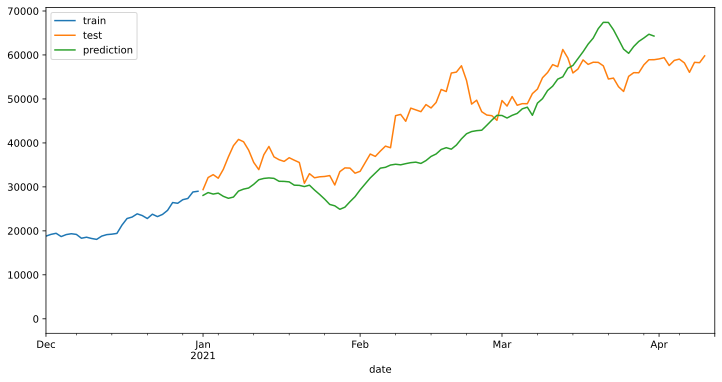

In [119]:
train_data['BTC'].plot(legend=True, label='train', figsize=(12,6))
test_data['BTC'].plot(legend=True, label='test')
test_predictions.plot(legend=True, label='prediction', xlim=['Dec 2020','2021-04-12'])

In [87]:
test_data.describe()

,BTC
count,100.000000
mean,46636.436800
std,9909.051469
min,29374.150000
25%,36775.790000
50%,48470.080000
75%,56018.647500
max,61243.080000


In [88]:
np.sqrt(mean_squared_error(test_data[test_predictions.index[0]:test_predictions.index[-1]], test_predictions))

21607.645569269363

In [89]:
mean_absolute_error(test_data[test_predictions.index[0]:test_predictions.index[-1]], test_predictions)

18938.860152631

/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


<AxesSubplot:xlabel='date'>

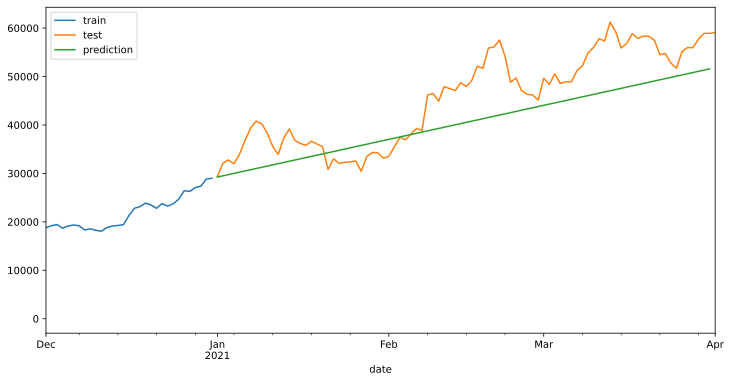

In [90]:
fitted_model = ExponentialSmoothing(train_data["BTC"], # DES = double exponential smoothing
                                          trend="add" # straight sloped trendline: add, curved: multiplicative, see description
                                         ).fit()
test_predictions = fitted_model.forecast(90)
train_data['BTC'].plot(legend=True, label='train', figsize=(12,6))
test_data['BTC'].plot(legend=True, label='test')
test_predictions.plot(legend=True, label='prediction', xlim=['Dec 2020','Apr 2021'])

In [91]:
test_data.describe()

,BTC
count,100.000000
mean,46636.436800
std,9909.051469
min,29374.150000
25%,36775.790000
50%,48470.080000
75%,56018.647500
max,61243.080000


In [92]:
mean_absolute_error(test_data[test_predictions.index[0]:test_predictions.index[-1]], test_predictions)

5756.360674630987

In [93]:
np.sqrt(mean_squared_error(test_data[test_predictions.index[0]:test_predictions.index[-1]], test_predictions))

6798.091535275757

## Evalulate model on test set

See above

## Brute force finding best predictions

Using a loop to find the best seasonal_periods parameter for the ExponentialSmoothing. We will not tune the trend or the seasonal parameter. 

In [94]:
def fit_predict(train_data, test_data, periods):
    fitted_model = ExponentialSmoothing(train_data["BTC"],
                                   trend='mul',
                                   seasonal='mul',
                                   seasonal_periods=periods).fit()
    
    test_predictions = fitted_model.forecast(90)
    
    return periods, np.sqrt(mean_squared_error(test_data[test_predictions.index[0]:test_predictions.index[-1]], test_predictions))

In [103]:
res = []
for periods in np.arange(2,200):
    print(f"Doing {periods}")
    res.append(fit_predict(train_data, test_data, periods))

Doing 2


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 3


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 4


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 5


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 6


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 7


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 8


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 9


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Doing 10


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 11


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 12


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 13


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 14


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 15


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 16


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 17


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 18


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 19


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 20


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 21


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 22


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 23


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 24


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 25


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 26


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 27


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 28


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 29


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 30


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 31


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 32


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 33


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 34


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 35


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 36


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 37


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 38


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 39


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 40


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 41


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 42


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 43


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 44


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 45


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 46


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 47


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 48


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 49


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 50


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 51


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 52


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 53


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 54


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 55


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 56


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 57


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 58


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 59


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 60


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 61


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 62


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 63


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 64


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 65


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 66


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 67


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 68


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 69


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 70


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 71


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 72


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 73


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 74


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 75


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 76


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 77


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 78


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 79


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 80


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 81


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 82


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 83


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 84


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 85


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 86


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 87


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 88


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 89


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 90


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 91


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 92


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 93


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 94


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 95


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 96


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 97


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 98


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 99


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 100


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 101


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 102


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 103


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 104


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 105


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 106


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 107


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 108


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 109


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 110


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 111


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 112


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 113


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 114


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 115


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 116


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 117


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 118


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 119


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 120


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 121


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 122


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 123


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 124


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 125


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 126


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 127


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 128


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 129


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 130


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 131


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 132


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 133


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 134


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 135


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 136


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 137


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 138


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 139


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 140


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 141


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 142


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 143


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 144


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 145


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 146


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 147


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 148


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 149


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 150


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 151


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 152


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 153


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 154


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Doing 155


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Doing 156


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Doing 157


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Doing 158


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 159


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 160


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 161


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 162


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 163


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 164


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 165


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 166


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 167


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 168


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 169


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 170


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 171


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 172


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 173


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 174


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 175


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 176


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 177


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 178


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 179


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 180


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 181


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 182


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 183


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 184


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 185


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 186


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 187


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 188


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 189


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 190


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 191


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 192


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 193


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 194


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 195


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 196


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 197


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 198


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Doing 199


/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [110]:
idx = np.argmin(np.asarray(res)[:,1])
res[idx]

(157, 4787.895361743912)

/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<AxesSubplot:xlabel='date'>

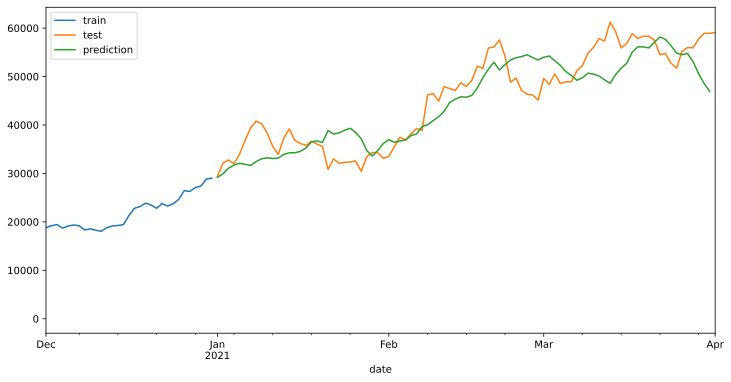

In [116]:
fitted_model = ExponentialSmoothing(train_data["BTC"],
                                   trend='mul',
                                   seasonal='mul',
                                   seasonal_periods=157).fit()


test_predictions = fitted_model.forecast(90)
train_data['BTC'].plot(legend=True, label='train', figsize=(12,6))
test_data['BTC'].plot(legend=True, label='test')
test_predictions.plot(legend=True, label='prediction', xlim=['Dec 2020','Apr 2021'])

## Stationarity

Series is stationary: Does not exhibit trend or seasonality.

In [98]:
from statsmodels.tsa.statespace.tools import diff

In [99]:
# first order difference
BTC['BTC'] - BTC['BTC'].shift(1)

date
2013-04-29        NaN
2013-04-30      -5.54
2013-05-01     -22.01
2013-05-02     -11.78
2013-05-03      -7.46
               ...   
2021-04-06    -865.52
2021-04-07   -2143.42
2021-04-08    2275.01
2021-04-09     -78.95
2021-04-10    1548.24
Freq: D, Name: BTC, Length: 2904, dtype: float64

In [100]:
diff(BTC["BTC"], k_diff=1) # k_diff is order of difference

date
2013-04-30      -5.54
2013-05-01     -22.01
2013-05-02     -11.78
2013-05-03      -7.46
2013-05-04      14.75
               ...   
2021-04-06    -865.52
2021-04-07   -2143.42
2021-04-08    2275.01
2021-04-09     -78.95
2021-04-10    1548.24
Freq: D, Name: BTC, Length: 2903, dtype: float64

<AxesSubplot:xlabel='date'>

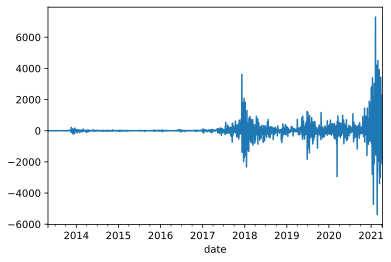

In [121]:
diff(BTC["BTC"], k_diff=1).plot()

# ACF and PACF 

Autocorrelation functions and partial autocorrelation fuctions 

#####  Autocorrelation

Correlation is a measure of the strength of the linear relationship between two values.

Autocorrelation plot shows the correlation of the time series with itself, lagged by the x time units (y: correlation, x: number of time units of lag).

Example: Sales data, lag 1, then this answers the question: How correlated are todays sales to yesterday sales.
So the ACF plot at x=1 shows the correlation between Day i and Day i-1 (with a straight line fit, then the slope is the correlation) for all possible time lags.

Two common patterns

1) gradual decline: some peaks with seasonality 

2) sharp drop off



##### Partial Autocorrelation

Calculate residual between the correlation plot (Day i vs Day i-1, then make a straight line fit) and so on.


ACF describes autocorellation between observation and other observation at a prior time step that includes direct and indirect dependence information

PACF describes only direct relationship between obervation and lag.

Both are used to choose order parameters for ARIMA based model. However, it is usually better to just do a grid search approach. But they can be used as a starting point.




Let's use some common datasets for this analysis.

In [120]:
import statsmodels.api as sm

In [122]:
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols

In [126]:
path = '../01.Original_data/time_series_course_Data/'
data_passengers = pd.read_csv(f"{path}airline_passengers.csv", parse_dates=True, index_col=0)
data_births = pd.read_csv(f"{path}daily_female_births.csv", parse_dates=True, index_col=0)

In [130]:
data_passengers

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [128]:
from pandas.plotting import lag_plot

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

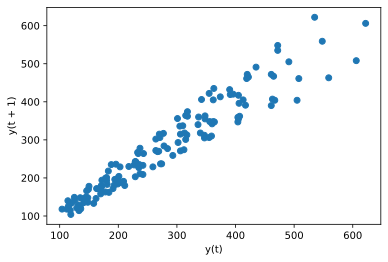

In [131]:
lag_plot(data_passengers["Passengers"])

The passenger dataset is a non-stationary dataset. The y (t+1) against y(t) - i.e., time series against lagged version of the plot - plot shows that there is a relationship.

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

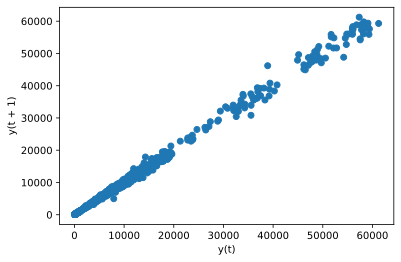

In [140]:
lag_plot(BTC["BTC"], lag=1)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

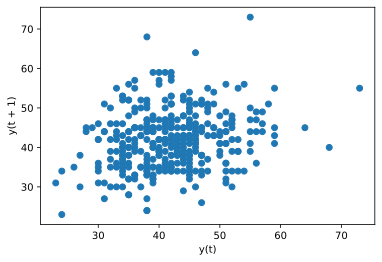

In [134]:
lag_plot(data_births["Births"])

For this non-stationary dataset, there is no strong correlation between days and days after.

In [141]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<AxesSubplot:xlabel='Month'>

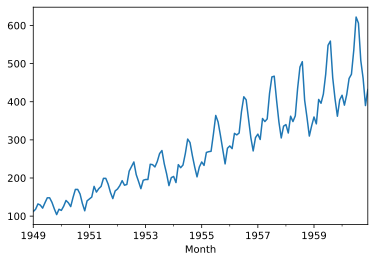

In [142]:
data_passengers["Passengers"].plot()

Definitely not a stationary!

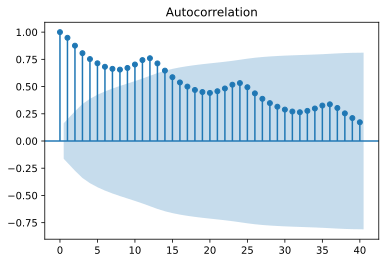

In [145]:
plot_acf(data_passengers['Passengers'], lags=40);

Little local maximums, so at some certain point the correlation increases (yearly indicators ar 12 months, 24 months, ...).


Shaded region represents the 95% confidence interval. Suggesting that correlation values outside are very likely highly to be correlations.

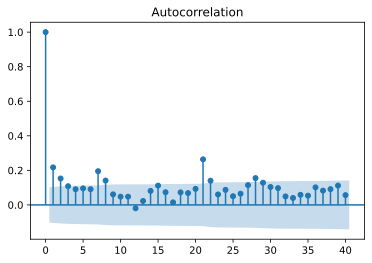

In [146]:
plot_acf(data_births['Births'], lags=40);

No indication of seasonality. 

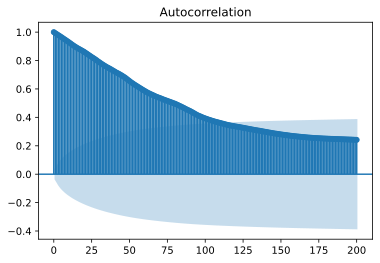

In [149]:
plot_acf(BTC['BTC'], lags=200);

### Partial Autocorrelation Plot

/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


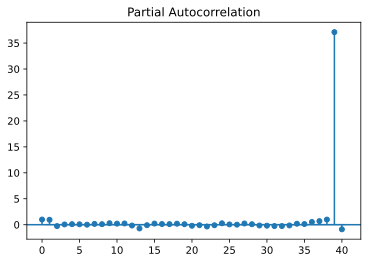

In [153]:
plot_pacf(data_passengers['Passengers'], lags=40);

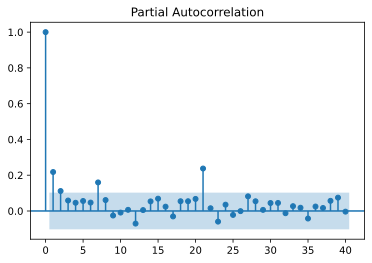

In [152]:
plot_pacf(data_births['Births'], lags=40);

If there is a sharp cutoff, one should add an AR term to the ARIMA model.

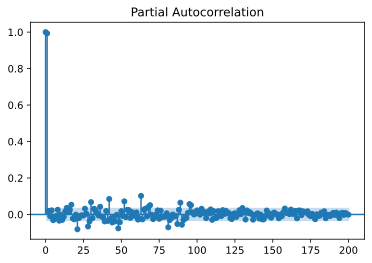

In [154]:
plot_pacf(BTC['BTC'], lags=200);